In [6]:
import datetime
from unittest import result
from loguru import logger
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import global_const as gconst
import numpy as np
import pickle
from lifelines import KaplanMeierFitter,CoxPHFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import logrank_test,multivariate_logrank_test
from scipy import stats
from tqdm import tqdm

from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import MultiComparison

from pathlib import Path



# import 

data_path_prefix = "./esrd"
project_path_prefix = "./"

origin_data_path=f"{data_path_prefix}/origin/ckd/"
data_path=f"{data_path_prefix}/processed/"
result_path=f"{project_path_prefix}/result/"

Path(result_path).mkdir(parents=True, exist_ok=True)


pdid_656 = pickle.load(open(f'{data_path}656_pdid','rb'))
days_656 = pickle.load(open(f'{data_path}656_days','rb'))
date_656 = pickle.load(open(f'{data_path}656_date','rb'))
visit_sta = pickle.load(open(f'{data_path}statistics_visit','rb'))
diet_sta = pickle.load(open(f'{data_path}statistics_diet','rb'))
visit_sta_first = pickle.load(open(f'{data_path}statistics_visit_first','rb'))
visit_sta_mean = pickle.load(open(f'{data_path}statistics_visit_mean','rb'))
diet_sta_first = pickle.load(open(f'{data_path}statistics_diet_first','rb'))
diet_sta_mean = pickle.load(open(f'{data_path}statistics_diet_mean','rb'))

labels_visit_sta = gconst.get_labels_statistics_visit()
labels_diet_sta = gconst.get_labels_statistics_diet()


(6557, 26)
(26, 26)
['date', 'water', 'protein', 'fat', 'carbohydrate', 'Calories', 'df', 'k', 'na', 'mg', 'ca', 'p', 'fe', 'zn', 'cu', 'mn', 'se', 'retinol', 'vitaminA', 'carotene', 'vitaminE', 'thiamine', 'riboflavin', 'nicotinic', 'ascorbic', 'dpi', 'dei']
26


<Figure size 1000x1000 with 0 Axes>

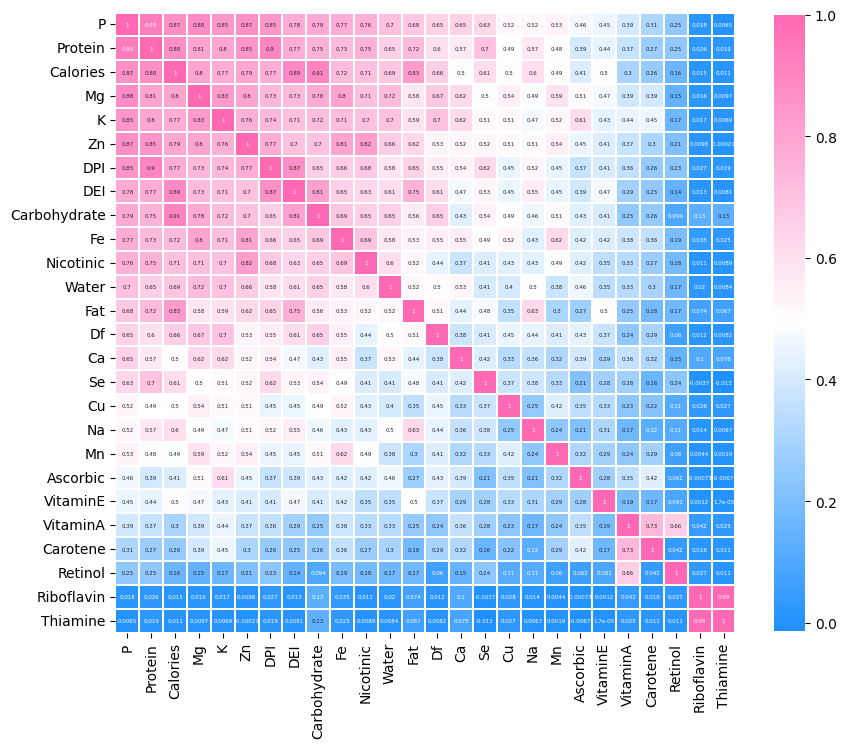

In [83]:
datas = []
for diet_person in diet_sta:
    no_date = np.array(diet_person)[:,1:]
    datas.append(no_date)
datas = np.concatenate(datas,axis=0)
print(datas.shape)

datas = np.array(datas,dtype=float)
# 计算皮尔森相关系数，两两计算，得到相关系数矩阵
corr = np.corrcoef(datas.T)
print(corr.shape)

# 计算每行的和，并排序，交换矩阵的某些行和列，使得相关系数和大的在前面
sum_corr = np.sum(corr,axis=0)
idx = np.argsort(sum_corr)[::-1]
corr = corr[idx]
corr = corr[:,idx]
print(labels_diet_sta)
labels = ['Water','Protein','Fat','Carbohydrate','Calories','Df',
                  'K','Na',
            'Mg','Ca','P','Fe','Zn','Cu',
                  'Mn','Se','Retinol','VitaminA','Carotene','VitaminE','Thiamine',
            'Riboflavin','Nicotinic','Ascorbic','DPI','DEI']

print(len(labels))
labels = np.array(labels)
labels = labels[idx]

# 画出一个热力图,黄色和紫色代表相关系数的大小，黄色代表正相关，紫色代表负相关
plt.figure(figsize=(10,10))
import matplotlib.colors as mcolors
pink_blue = mcolors.LinearSegmentedColormap.from_list("pink_blue_light", ["#1e90ff", "#ffffff", "#ff69b4"])
color = pink_blue
# color = 'coolwarm'
# annot 保留两位小数
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True,xticklabels=labels,yticklabels=labels,cmap=color, square=True,linewidths=0.05, annot_kws={"size": 4}, cbar_kws={'shrink': .8})

plt.savefig(f"{result_path}/diet_heatmap.pdf", bbox_inches='tight')
plt.show()

In [75]:
print(len(labels_diet_sta)  )

27


In [2]:
# read origin.csv
import pandas as pd
origin = pd.read_csv(f"./origin.csv")

In [3]:
# sort by amount
origin = origin.sort_values(by='amount',ascending=False)
# 加一列，ratio / 656
origin['ratio'] = origin['amount'] / 656
origin['ratio'] = origin['ratio'].apply(lambda x: round(x,2))

In [4]:
origin

,category,category_eng,amount,ratio
0,慢性肾小球肾炎,Chronic Glomerulonephritis,333,0.51
1,糖尿病肾病,Diabetic Nephropathy,333,0.51
2,高血压肾损害,Hypertensive Renal Damage,134,0.20
6,慢性间质性肾炎,Chronic Interstitial Nephritis,98,0.15
7,不明,Unknown,63,0.10
3,常染色体显性多囊肾病,Autosomal Dominant Polycystic Kidney Disease,33,0.05
5,梗阻性肾病,Obstructive Nephropathy,17,0.03
8,肾动脉硬化,Renal Arteriosclerosis,16,0.02
13,缺血性肾病,Ischemic Nephropathy,11,0.02
9,慢性肾盂肾炎,Chronic Pyelonephritis,10,0.02


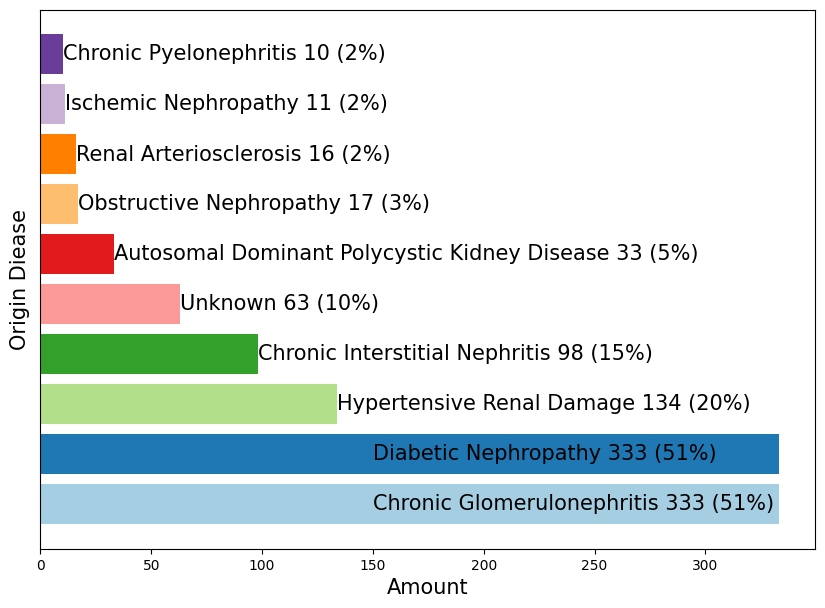

In [7]:



import pandas as pd
import matplotlib.pyplot as plt

def plot_pie_chart_with_others(df):
    # Sort the DataFrame by 'amount' in descending order
    df = df.sort_values(by='amount', ascending=False)
    
    # Separate the top 10 categories and the rest
    top_10 = df.iloc[:6]
    others = df.iloc[6:]
    
    # Sum the 'amount' for the 'others' category
    others_sum = others['amount'].sum()
    
    # Create a new DataFrame for the pie chart
    pie_df = top_10.copy()
    pie_df = pie_df.append({'category': '其他', 'category_eng': 'Others', 'amount': others_sum}, ignore_index=True)
    
    # Plot the pie chart
    plt.figure(figsize=(10, 7))
    plt.pie(pie_df['amount'], labels=pie_df['category_eng'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    plt.title('Category Distribution')
    plt.axis('equal')
    plt.show()



def plot_pie_chart_with_others(df):
    # Sort the DataFrame by 'amount' in descending order
    df = df.sort_values(by='amount', ascending=False)
    
    # Separate the top 10 categories and the rest
    top_10 = df.iloc[:8]
    others = df.iloc[8:]
    
    # Sum the 'amount' for the 'others' category
    others_sum = others['amount'].sum()
    
    # Create a new DataFrame for the pie chart
    pie_df = top_10.copy()
    pie_df = pie_df.append({'category': '其他', 'category_eng': 'Others', 'amount': others_sum}, ignore_index=True)
    
    #浅色一点的颜色
    import seaborn as sns

    colors = sns.color_palette("pastel")
    # Plot the pie chart
    plt.figure(figsize=(10, 7))
    wedges, texts, autotexts = plt.pie(pie_df['amount'], labels=pie_df['category_eng'], autopct='%1.1f%%', startangle=140, colors=colors, textprops=dict(color="black"))
    
    # plt.title('Category Distribution')
    plt.axis('equal')
    
    # 让数字显示在外面，不要重叠，不要显示在图里面
    plt.setp(autotexts, size=8, weight="bold")

    # 不要给块标题，给图例
    
    # Add legend
    # plt.legend(wedges, pie_df['catxegory_eng'], title="Categories", loc="upper right", bbox_to_anchor=(1.3, 1))
    
    plt.show()
# Plot the pie chart for the 'category' column
# plot_pie_chart_with_others(origin)


def draw_a_bar_chart(df):
    # Sort the DataFrame by 'amount' in descending order
    df = df.sort_values(by='amount', ascending=False)
    top_10 = df.iloc[:10]
    others = df.iloc[10:]
    
    # Sum the 'amount' for the 'others' category
    others_sum = others['amount'].sum()
    
    # Create a new DataFrame for the pie chart
    pie_df = top_10.copy()
    # pie_df = pie_df.append({'category': '其他', 'category_eng': 'Others', 'amount': others_sum}, ignore_index=True)

    # 加一列比例
    pie_df['ratio'] = pie_df['amount'] / 656

    # 比例写在条形图上面
    # 横着的条形图，


    font_size = 15
    # Plot the bar chart
    plt.figure(figsize=(10, 7))
    plt.barh(pie_df['category_eng'], pie_df['amount'], color=plt.cm.Paired.colors)
    for i, amount, ratio, category in zip(range(10), pie_df['amount'], pie_df['ratio'], pie_df['category_eng']):
        plt.text(min(amount,150), i, f'{category} {amount} ({ratio*100:.0f}%)', ha='left', va='center', fontsize=font_size)
    plt.xlabel('Amount', fontsize=font_size)
    plt.ylabel('Origin Diease', fontsize=font_size)
    # plt.title('Category Distribution')
    # y轴不显示分类
    plt.yticks([])
    
    # plt.show()
    plt.savefig(f"{result_path}/category_distribution.pdf", bbox_inches='tight')
    


draw_a_bar_chart(origin)